<a href="https://colab.research.google.com/github/Lim-Calculus/Deep-Learning-with-PyTorch-Image-Segmentation/blob/main/Deep_Learning_Semantic_Segmentation_with_PyTorch_(ONNX_Inference).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch torch torchvision
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-aett_pvi
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-aett_pvi
  Resolved https://github.com/albumentations-team/albumentations to commit c053776649a941cd9b9ae8e83db5a450af93d471
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


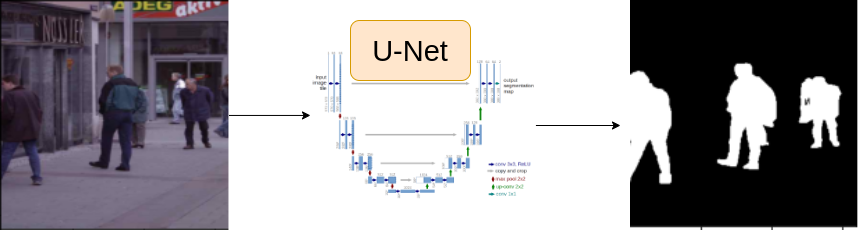

# Some Common Imports

In [ ]:
import sys
sys.path.append('Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torch.utils.data import Dataset
import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = 'Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '.'

DEVICE = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {DEVICE} device")

EPOCHS = 35
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 32

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

Using cuda device


In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[4]
image_path  = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


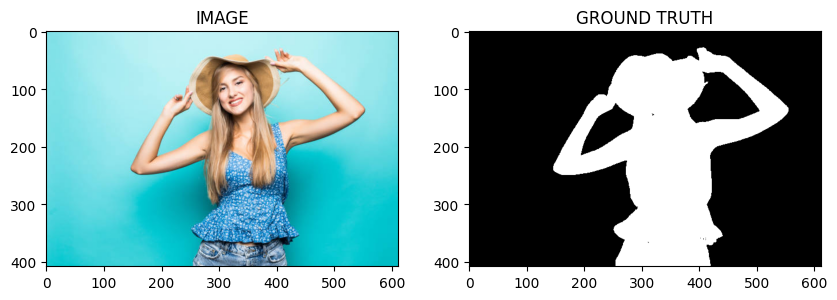

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w,c)
    if mask.ndim == 2:
      mask = np.expand_dims(mask, axis=-1)

    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    image = np.reshape(image, (IMG_SIZE, IMG_SIZE, 3))
    mask = np.reshape(mask, (IMG_SIZE, IMG_SIZE, 1))

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    image = np.reshape(image, (IMG_SIZE, IMG_SIZE, 3))
    mask = np.reshape(mask, (IMG_SIZE, IMG_SIZE, 1))

    #(h,w,c) -> (c, h, w)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)
    return image, mask




In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


torch.Size([3, 320, 320]) torch.Size([1, 320, 320])


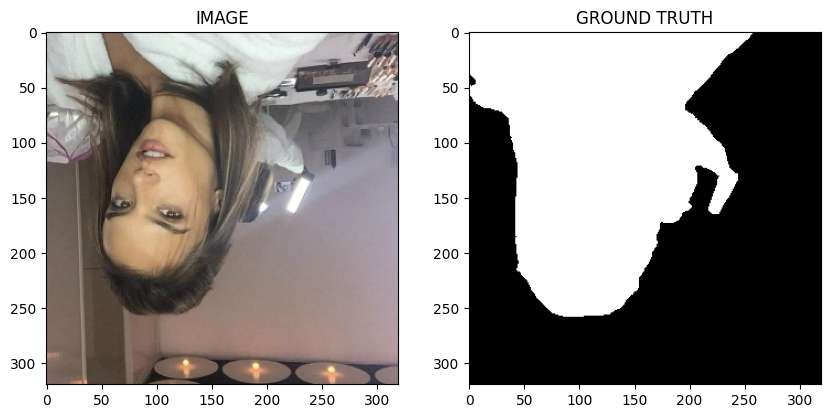

In [ ]:
idx = 1
image, mask = trainset[idx]
print(image.shape, mask.shape)
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total no of Batches in trainloader : {len(trainloader)}")
print(f"Total no of Batches in validloader : {len(validloader)}")

Total no of Batches in trainloader : 8
Total no of Batches in validloader : 2


In [ ]:
for image, mask in trainloader:
    break

print(f'One batch image shape : {image.shape}')
print(f'One batch mask shape : {mask.shape}')

One batch image shape : torch.Size([32, 3, 320, 320])
One batch mask shape : torch.Size([32, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss



In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None ##output logits
        )

    def forward(self, images, masks = None):

        logits = self.arc(images)

        if masks is not None:
            loss1 = DiceLoss(mode = 'binary', from_logits=True)(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            logits, loss = model(images, masks)
            total_loss += loss.item()

    return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, cooldown=0, min_lr=1e-7)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        print("SAVED-MODEL")
        best_valid_loss = valid_loss

    print(f"Epoch : {i+1}/{EPOCHS} : Train_loss :{train_loss}, Valid_loss : {valid_loss}")

100%|██████████| 2/2 [00:00<00:00,  2.28it/s]


SAVED-MODEL
Epoch : 1/35 : Train_loss :1.0392169579863548, Valid_loss : 11.41755723953247


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


SAVED-MODEL
Epoch : 2/35 : Train_loss :0.4908970333635807, Valid_loss : 0.6445662975311279


100%|██████████| 2/2 [00:00<00:00,  2.31it/s]


SAVED-MODEL
Epoch : 3/35 : Train_loss :0.3161759041249752, Valid_loss : 0.49489089846611023


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


SAVED-MODEL
Epoch : 4/35 : Train_loss :0.24463684484362602, Valid_loss : 0.20114780217409134


100%|██████████| 2/2 [00:00<00:00,  2.27it/s]


Epoch : 5/35 : Train_loss :0.24403821863234043, Valid_loss : 0.27744369208812714


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Epoch : 6/35 : Train_loss :0.21323526091873646, Valid_loss : 0.20954228937625885


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


SAVED-MODEL
Epoch : 7/35 : Train_loss :0.20150097832083702, Valid_loss : 0.19828476756811142


100%|██████████| 2/2 [00:00<00:00,  2.42it/s]


Epoch : 8/35 : Train_loss :0.18965105153620243, Valid_loss : 0.24530214816331863


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


Epoch : 9/35 : Train_loss :0.20240236073732376, Valid_loss : 0.24383533746004105


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


Epoch : 10/35 : Train_loss :0.16878538951277733, Valid_loss : 0.20600385963916779


100%|██████████| 2/2 [00:00<00:00,  2.43it/s]


Epoch : 11/35 : Train_loss :0.15795236453413963, Valid_loss : 0.22471186518669128


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


SAVED-MODEL
Epoch : 12/35 : Train_loss :0.15168065577745438, Valid_loss : 0.19702719897031784


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


SAVED-MODEL
Epoch : 13/35 : Train_loss :0.16577343456447124, Valid_loss : 0.19626615196466446


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


Epoch : 14/35 : Train_loss :0.1459409473463893, Valid_loss : 0.21021950244903564


100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


Epoch : 15/35 : Train_loss :0.14153909496963024, Valid_loss : 0.22152085602283478


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


SAVED-MODEL
Epoch : 16/35 : Train_loss :0.11970832291990519, Valid_loss : 0.19545340538024902


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


SAVED-MODEL
Epoch : 17/35 : Train_loss :0.11678678449243307, Valid_loss : 0.18406002968549728


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


SAVED-MODEL
Epoch : 18/35 : Train_loss :0.11396575719118118, Valid_loss : 0.17775443941354752


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


SAVED-MODEL
Epoch : 19/35 : Train_loss :0.10552977118641138, Valid_loss : 0.1756659746170044


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


SAVED-MODEL
Epoch : 20/35 : Train_loss :0.10453360714018345, Valid_loss : 0.17345299571752548


100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


Epoch : 21/35 : Train_loss :0.08990021049976349, Valid_loss : 0.18122480064630508


100%|██████████| 2/2 [00:00<00:00,  2.41it/s]


Epoch : 22/35 : Train_loss :0.1320237647742033, Valid_loss : 0.18672101199626923


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Epoch : 23/35 : Train_loss :0.10583191178739071, Valid_loss : 0.22279959917068481


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


Epoch : 24/35 : Train_loss :0.0989706888794899, Valid_loss : 0.18563320487737656


100%|██████████| 2/2 [00:00<00:00,  2.33it/s]


SAVED-MODEL
Epoch : 25/35 : Train_loss :0.1074814535677433, Valid_loss : 0.17186818271875381


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Epoch : 26/35 : Train_loss :0.12483642902225256, Valid_loss : 0.19588980078697205


100%|██████████| 2/2 [00:00<00:00,  2.36it/s]


Epoch : 27/35 : Train_loss :0.11179543659090996, Valid_loss : 0.17878153920173645


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]


Epoch : 28/35 : Train_loss :0.12801838666200638, Valid_loss : 0.17852389812469482


100%|██████████| 2/2 [00:00<00:00,  2.34it/s]


Epoch : 29/35 : Train_loss :0.12864701636135578, Valid_loss : 0.19270585477352142


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


Epoch : 30/35 : Train_loss :0.10682837758213282, Valid_loss : 0.18559754639863968


100%|██████████| 2/2 [00:00<00:00,  2.40it/s]


Epoch : 31/35 : Train_loss :0.09476543869823217, Valid_loss : 0.19163266569375992


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Epoch : 32/35 : Train_loss :0.0940366592258215, Valid_loss : 0.21400190889835358


100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


Epoch : 33/35 : Train_loss :0.074290432035923, Valid_loss : 0.22011631727218628


100%|██████████| 2/2 [00:00<00:00,  2.45it/s]


Epoch : 34/35 : Train_loss :0.07716391235589981, Valid_loss : 0.21140935271978378


100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

Epoch : 35/35 : Train_loss :0.07201276812702417, Valid_loss : 0.20468606799840927


# Task 9 : Inference

In [ ]:
idx = 50

model.load_state_dict(torch.load('best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)* 1.0

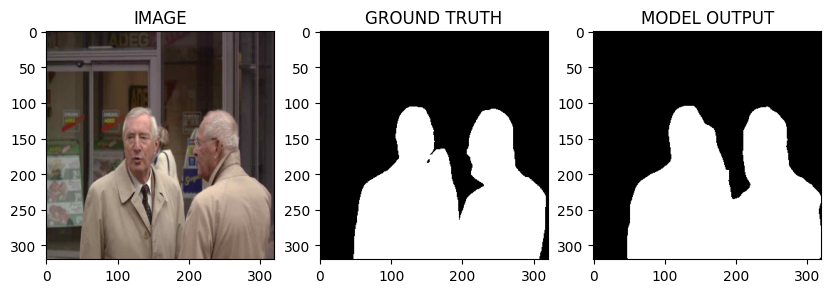

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

## Convert to ONNX

In [ ]:
## Export to ONNX
# Input to the model
onnx_dynamic_batch_size = 2
x = torch.randn(onnx_dynamic_batch_size, 3, IMG_SIZE, IMG_SIZE, requires_grad=True)
model.to('cpu')
torch_out = model(x.to('cpu'))
model.eval()
# Export the model
torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "segmentation.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                   dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}}
                 )

/opt/conda/lib/python3.10/site-packages/torch/onnx/symbolic_helper.py:833: UserWarning: You are trying to export the model with onnx:Resize for ONNX opset version 10. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator.
  warnings.warn(


## Inference in ONNX

In [ ]:
import onnx

onnx_model = onnx.load("segmentation.onnx")
onnx.checker.check_model(onnx_model)


In [ ]:
!pip3 install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.8 MB/s eta 0:00:00


In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("segmentation.onnx", providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


In [ ]:
idx = 50
image, mask = validset[idx]
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(image.unsqueeze(0))}
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0]
print(img_out_y.shape)
pred_mask = torch.sigmoid(torch.Tensor(img_out_y))
pred_mask = (pred_mask > 0.5)* 1.0

(1, 1, 320, 320)


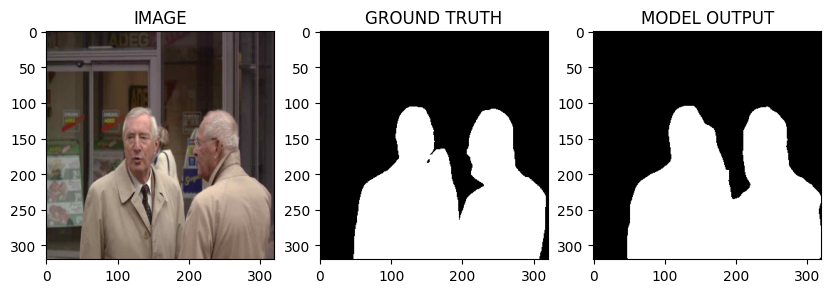

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))